In [1]:
# basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for pre-processing
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
import string

# for topic modeling
import gensim
from gensim import corpora

# for wordcloud
from wordcloud import WordCloud

# TDM, TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# SVD
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

# Clustering, K-Means
from sklearn.cluster import KMeans

# topic modeling
import gensim 
from gensim import corpora

# collocation, bigram, trigram
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

# regular expression
import re

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

C:\Users\raymo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Read in Data

In [2]:
data = pd.read_csv('C:/Users/raymo/OneDrive/Desktop/KE5205 - Text Mining/Assignment/nus-text-mining-master/processed_data_1014.csv')
data = data.rename(columns = {'Unnamed: 0' : 'index', 'category':'industry'})

# Function Declaration

In [3]:
# function to get unique values 
def unique(data, col_name): 
        return data[col_name].unique()

# Data Preparation

In [4]:
# Change job titles to lower case for text analysis later
data['job_title'] = data['job_title'].str.lower()

# Change job requirements to lower case for text analysis later
data['job_requirement_nnp'] = data['job_requirement_nnp'].str.lower()

# Replace short forms for text analysis later
data['job_title'] = data['job_title'].str.replace('snr', 'senior')
data['job_title'] = data['job_title'].str.replace('assoc', 'associate')
data['job_title'] = data['job_title'].str.replace('associateiate', 'associate')

## Data Preparation for Salary Analysis

In [5]:
# Replace 0 values to NaN so that it will not influence boxplot
data.salary_max.loc[data['salary_max'] == 0] = float('nan')
data.salary_min.loc[data['salary_min'] == 0] = float('nan')

C:\Users\raymo\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# Creating a feature "salary_mid" so that this can be used as a basis of comparison for all roles
data.insert(10, 'salary_mid', float('nan'), allow_duplicates=True)
print(list(data))

['industry', 'company', 'employment_type', 'job_description', 'job_requirement', 'job_skills', 'job_title', 'job_uuid', 'location', 'salary_max', 'salary_mid', 'salary_min', 'seniority', 'job_requirement_nn', 'job_description_nn', 'job_requirement_nnp', 'job_description_nnp', 'job_requirement_vb', 'job_description_vb', 'latitude', 'longtitude', 'job_experience', 'job_degree']


In [7]:
# Calculating the salary mid points for each role
data['salary_mid'] = data[['salary_max','salary_min']].mean(axis=1)

## Data Preparation for Industry Analysis

In [8]:
# There are many instances where ' ...' is present. These needs to be removed.
a = [i.replace(' ...', '') for i in data.industry]
data['industry'] = pd.DataFrame(a)
print(data['industry'])

0                         Engineering
1                         Engineering
2      Accounting ,Auditing ,Taxation
3           Sciences ,Laboratory ,R&D
4           Sciences ,Laboratory ,R&D
5                         Engineering
6               Public ,Civil Service
7              Information Technology
8                 Banking and Finance
9                 Banking and Finance
10             Information Technology
11                Banking and Finance
12             Information Technology
13          Sciences ,Laboratory ,R&D
14             Information Technology
15                        Consulting 
16             Information Technology
17         Healthcare ,Pharmaceutical
18             Information Technology
19                Banking and Finance
20          Sciences ,Laboratory ,R&D
21                Banking and Finance
22          Sciences ,Laboratory ,R&D
23                Advertising ,Media 
24                        Engineering
25          Sciences ,Laboratory ,R&D
26          

## Career Stage Identification
By observation, Seniority does not provide an accurate gauge in the stage of career path. For instance, a "Professional" broadly covers both Entry Level and Management Roles (e.g. Manager / Director) in the datasource.

It would be best to identify entry level / senior / management level roles through job titles instead. Management level jobs would have the word "Lead/Manager/Director/VP/President" in their titles. Once these are identified, Senior level jobs would have the word "senior" in the title. The remaining jobs would be classified as Professional level jobs.

In [9]:
#Create a new column to determine the stage of career path
data.insert(14, 'Career_Stage', 'Unknown', allow_duplicates=True)
data

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
0,Engineering,PROPERTYGURU PTE. LTD.,Permanent,Our websites attract more than 100 million mon...,Bachelor’s degree in IT or relevant field. Alt...,"Data Analysis, SQL, Microsoft Excel, Microsoft...",data engineer,82e462a13cadc477f93d57ad6812d1d1,Central,7000.0,...,Unknown,websites page-views click-stream behaviour dat...,it azkaban airflow python c++ java go scala ka...,Property Guru Southeast Asia.Our Data Science ...,be working Working authoring write is is be is...,attract result has is empowered build using be...,1.300213,103.837287,2.0,Bachelor
1,Engineering,PROPERTYGURU PTE. LTD.,Permanent,Our websites attract more than 100 million mon...,Bachelor’s degree in IT or relevant field. Alt...,"Data Analysis, SQL, Microsoft Excel, Microsoft...",data engineer,763708ca5a581db4389a766ef71654a0,Central,9000.0,...,Unknown,websites page-views click-stream behaviour dat...,it azkaban airflow python c++ java go scala ka...,Property Guru Southeast Asia.Our Data Science ...,be working Working authoring write is is be is...,attract result has is empowered build using be...,1.300213,103.837287,2.0,Bachelor
2,"Accounting ,Auditing ,Taxation",ERNST & YOUNG ADVISORY PTE. LTD.,Permanent,Join Fraud Investigation & Dispute Services (F...,To qualify for the role you must have. Strong ...,"Accounting, Microsoft Excel, Microsoft Word, G...",fraud investigation & dispute services (fids) ...,c59d6037f441a5b3b43ca4daff84806a,Central,16000.0,...,Unknown,Fraud Investigation Dispute Services Assurance...,life science english plus opportunities,Fraud Investigation Dispute Services Assurance...,qualify have is encouraged apply run managing ...,Join help work be aligned works experience tai...,1.280895,103.851677,8.0,NaN
3,"Sciences ,Laboratory ,R&D",A*STAR RESEARCH ENTITIES,Contract,"The Agency for Science, Technology and Researc...",Bachelor or Master's Degree in physical scienc...,"Matlab, Algorithms, C++, Machine Learning, C, ...",research engineer / senior research engineer (...,cec1905d6444838c2d7108c1a04049a3,West,5000.0,...,Unknown,Agency Science Technology Research ( A*STAR ) ...,technical,Agency Science Technology Research ( A*STAR ) ...,building been specialise interpret seek develo...,is fosters drive transform .For please advance...,1.285407,103.850568,5.0,"Bachelor, Master"
4,"Sciences ,Laboratory ,R&D",A*STAR RESEARCH ENTITIES,Contract,"Specialize in applying data analytics, machine...",PhD in Power System operation and analysis or ...,"R&D, Molecular Biology, Biotechnology, Lifesci...","scientist (power system analytics), epgc",d2da04bb4033006cb580fc80e752fa9e,West,11800.0,...,Unknown,data analytics machine learning data mining te...,power system c/c++ python jurong island,NaN,related work work are ) are include based be a...,Specialize applying be prepare,1.285407,103.850568,NaN,"Master, PhD"
5,Engineering,Company Undisclosed,Permanent,About The Role. As IAG focuses on creating an ...,These are the skills and experience we are loo...,"Analytics, Data Analysis, Analysis, Statistica...",data scientist,972f2d0cd68c45fbf7d50920fc229036,Central,12000.0,...,Unknown,Role IAG organisation Data Scientist role data...,sql python py spark scala aws gcp advanced ten...,IAG Data Scientist IAG Data Sciences IAG ( Bus...,are are looking manipulating processing extrac...,focuses creating is is delivering be built con...,1.279468,103.853750,NaN,"Master, PhD"
6,"Public ,Civil Service",Smart Nation and Digital Government Office,Full Time,The Smart Nation and Digital Government Office...,We are in search of motivated individuals who ...,"Human Resources, Employee Relations, Recruitin...",manager / senior manager (talent and manpower),cb3cb0fd4276956c30baab4084802b3a,NaN,NaN,...,Unknown,Sm

### Management Level Roles

In [10]:
# Looking for Management level Roles
management_result = data['job_title'].str.contains('lead|manager|director|president|VP', flags=re.IGNORECASE, regex=True)
management_result_idx = management_result.index[management_result == 1]
data.iloc[management_result_idx]

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
2,"Accounting ,Auditing ,Taxation",ERNST & YOUNG ADVISORY PTE. LTD.,Permanent,Join Fraud Investigation & Dispute Services (F...,To qualify for the role you must have. Strong ...,"Accounting, Microsoft Excel, Microsoft Word, G...",fraud investigation & dispute services (fids) ...,c59d6037f441a5b3b43ca4daff84806a,Central,16000.0,...,Unknown,Fraud Investigation Dispute Services Assurance...,life science english plus opportunities,Fraud Investigation Dispute Services Assurance...,qualify have is encouraged apply run managing ...,Join help work be aligned works experience tai...,1.280895,103.851677,8.0,NaN
6,"Public ,Civil Service",Smart Nation and Digital Government Office,Full Time,The Smart Nation and Digital Government Office...,We are in search of motivated individuals who ...,"Human Resources, Employee Relations, Recruitin...",manager / senior manager (talent and manpower),cb3cb0fd4276956c30baab4084802b3a,NaN,NaN,...,Unknown,Smart Nation Digital Government Office ( SNDGO...,value singapore smart nation analytical date.s...,Smart Nation Digital Government Office ( SNDGO...,are share take going provide shaping conceptua...,plans prioritizes raises builds promotes takes...,NaN,NaN,2.0,NaN
8,Banking and Finance,Company Undisclosed,Full Time,". Lead the definition of activities, scope, an...",Knowledge in at least 1 of the following data ...,"Management, Leadership, Strategy, Strategic Pl...","vice president, portfolio & regulatory managem...",e11a65ce7a59ca9f6a19bcf76c62ac68,Central,10000.0,...,Unknown,definition activities scope timelines data sci...,mining nlpgraph network analysis deep learning...,Guide Work Hive Data Work Data Scala Java API,following Text applied asking answering distri...,support following discover interpret document ...,1.285407,103.850568,NaN,Bachelor
9,Banking and Finance,Company Undisclosed,Full Time,". Lead the definition of activities, scope, an...",Knowledge in at least 1 of the following data ...,"Management, Leadership, Strategy, Strategic Pl...","vice president, portfolio & regulatory managem...",dda2dea97c28a907fe2b7ee0346d4e77,Central,10000.0,...,Unknown,definition activities scope timelines data sci...,mining nlpgraph network analysis deep learning...,Guide Work Hive Data Work Data Scala Java API,following Text applied asking answering distri...,support following discover interpret document ...,1.285407,103.850568,NaN,Bachelor
14,Information Technology,DEEP MIND CAPITAL PTE. LTD.,Full Time,Deep Mind.Capital is a digital asset managemen...,Bachelor’s degree with 3 years minimum experie...,"Management, Leadership, Project Management, St...",product manager,8c9fe53d59f2e9098b7dbd3c278b7fea,Central,8000.0,...,Unknown,Mind.Capital asset management company investme...,business finance it ( order management system ...,NaN,related building building developing distributed,is strives develop combined stack learning are...,1.285785,103.852220,3.0,Bachelor
17,"Healthcare ,Pharmaceutical",Health Promotion Board,Permanent,"Assistant Director, Data Science. Overview of ...",. Qualification or work experience in data sci...,"Analytics, Data Analysis, Analysis, Statistica...","assistant director, data science",d2d8e6c23fb3649e7b224cbb6501b4cc,NaN,NaN,...,Unknown,Assistant Director Data Science Overview Polic...,python sql ) able,Assistant Director Data Science Overview Polic...,be required leading collaborating work oversee...,advance leveraging drive lead delivering be do...,1.279331,103.838315,5.0,NaN
21,Banking and Finance,CITIBANK N.A.,Full Time,Job Purpose:The charter of this role is to pro...,The ideal candidate will meet the following re...,"Business Analysis, Project Management, Managem...",gcg - business analyst manager - 17053710,

In [11]:
# Update the "career stage" column
data.loc[management_result_idx,['Career_Stage']] = 'Management'
data.iloc[management_result_idx]

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
2,"Accounting ,Auditing ,Taxation",ERNST & YOUNG ADVISORY PTE. LTD.,Permanent,Join Fraud Investigation & Dispute Services (F...,To qualify for the role you must have. Strong ...,"Accounting, Microsoft Excel, Microsoft Word, G...",fraud investigation & dispute services (fids) ...,c59d6037f441a5b3b43ca4daff84806a,Central,16000.0,...,Management,Fraud Investigation Dispute Services Assurance...,life science english plus opportunities,Fraud Investigation Dispute Services Assurance...,qualify have is encouraged apply run managing ...,Join help work be aligned works experience tai...,1.280895,103.851677,8.0,NaN
6,"Public ,Civil Service",Smart Nation and Digital Government Office,Full Time,The Smart Nation and Digital Government Office...,We are in search of motivated individuals who ...,"Human Resources, Employee Relations, Recruitin...",manager / senior manager (talent and manpower),cb3cb0fd4276956c30baab4084802b3a,NaN,NaN,...,Management,Smart Nation Digital Government Office ( SNDGO...,value singapore smart nation analytical date.s...,Smart Nation Digital Government Office ( SNDGO...,are share take going provide shaping conceptua...,plans prioritizes raises builds promotes takes...,NaN,NaN,2.0,NaN
8,Banking and Finance,Company Undisclosed,Full Time,". Lead the definition of activities, scope, an...",Knowledge in at least 1 of the following data ...,"Management, Leadership, Strategy, Strategic Pl...","vice president, portfolio & regulatory managem...",e11a65ce7a59ca9f6a19bcf76c62ac68,Central,10000.0,...,Management,definition activities scope timelines data sci...,mining nlpgraph network analysis deep learning...,Guide Work Hive Data Work Data Scala Java API,following Text applied asking answering distri...,support following discover interpret document ...,1.285407,103.850568,NaN,Bachelor
9,Banking and Finance,Company Undisclosed,Full Time,". Lead the definition of activities, scope, an...",Knowledge in at least 1 of the following data ...,"Management, Leadership, Strategy, Strategic Pl...","vice president, portfolio & regulatory managem...",dda2dea97c28a907fe2b7ee0346d4e77,Central,10000.0,...,Management,definition activities scope timelines data sci...,mining nlpgraph network analysis deep learning...,Guide Work Hive Data Work Data Scala Java API,following Text applied asking answering distri...,support following discover interpret document ...,1.285407,103.850568,NaN,Bachelor
14,Information Technology,DEEP MIND CAPITAL PTE. LTD.,Full Time,Deep Mind.Capital is a digital asset managemen...,Bachelor’s degree with 3 years minimum experie...,"Management, Leadership, Project Management, St...",product manager,8c9fe53d59f2e9098b7dbd3c278b7fea,Central,8000.0,...,Management,Mind.Capital asset management company investme...,business finance it ( order management system ...,NaN,related building building developing distributed,is strives develop combined stack learning are...,1.285785,103.852220,3.0,Bachelor
17,"Healthcare ,Pharmaceutical",Health Promotion Board,Permanent,"Assistant Director, Data Science. Overview of ...",. Qualification or work experience in data sci...,"Analytics, Data Analysis, Analysis, Statistica...","assistant director, data science",d2d8e6c23fb3649e7b224cbb6501b4cc,NaN,NaN,...,Management,Assistant Director Data Science Overview Polic...,python sql ) able,Assistant Director Data Science Overview Polic...,be required leading collaborating work oversee...,advance leveraging drive lead delivering be do...,1.279331,103.838315,5.0,NaN
21,Banking and Finance,CITIBANK N.A.,Full Time,Job Purpose:The charter of this role is to pro...,The ideal candidate will meet the following re...,"Business Analysis, Project Management, Managem...",gcg - business analyst m

In [12]:
# Identification of management roles (0 to 3 years of experience required).
management_df = data.iloc[management_result_idx]
check = management_df['job_experience'] <= 3
check_idx = check.index[check == 1]
data.iloc[check_idx]

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
6,"Public ,Civil Service",Smart Nation and Digital Government Office,Full Time,The Smart Nation and Digital Government Office...,We are in search of motivated individuals who ...,"Human Resources, Employee Relations, Recruitin...",manager / senior manager (talent and manpower),cb3cb0fd4276956c30baab4084802b3a,NaN,NaN,...,Management,Smart Nation Digital Government Office ( SNDGO...,value singapore smart nation analytical date.s...,Smart Nation Digital Government Office ( SNDGO...,are share take going provide shaping conceptua...,plans prioritizes raises builds promotes takes...,NaN,NaN,2.0,NaN
14,Information Technology,DEEP MIND CAPITAL PTE. LTD.,Full Time,Deep Mind.Capital is a digital asset managemen...,Bachelor’s degree with 3 years minimum experie...,"Management, Leadership, Project Management, St...",product manager,8c9fe53d59f2e9098b7dbd3c278b7fea,Central,8000.0,...,Management,Mind.Capital asset management company investme...,business finance it ( order management system ...,NaN,related building building developing distributed,is strives develop combined stack learning are...,1.285785,103.852220,3.0,Bachelor
98,Information Technology,JANIO TECHNOLOGIES PRIVATE LIMITED,Full Time,"About Janio:At Janio, we are building Asia’s l...",Roles and Responsibilities:Our Customer Succes...,"Sales, Account Management, Marketing, Customer...",customer success manager,bb8a86e1e7bac7992c5e67c23d044acf,Central,5000.0,...,Management,Janio Janio Asia s logistics network delivery ...,operations sales english,Janio Janio Asia Southeast Asia Asia Singapore...,serves trusted are involved serving help carry...,are building leading providing operate serving...,1.326013,103.799936,2.0,NaN
165,Banking and Finance,DBS BANK LTD.,Permanent,Job Purpose. Build and improve machine learnin...,"PhD/Masters/Bachelors in Computer Science, Com...","Management, Banking, Risk Management, Leadersh...","avp / senior associate, machine learning engin...",b3fa00eab03bc7ee01a600fd70041e2d,East,11000.0,...,Management,Job Purpose machine learning analytics platfor...,computer science computer engineering statisti...,Job Purpose Work API RDBMS GPU Relationships I...,working stack is is is is is work is working,Build improve create optimize productionize Ke...,1.279017,103.854465,2.0,"Bachelor, Master, PhD"
206,"Marketing ,Public Relations",BIPO SERVICE (SINGAPORE) PTE. LTD.,Full Time,Our Client's Company background: Byte. Mod (al...,Bachelor’s degree is required.Minimum 3 years ...,"Marketing, Marketing Strategy, Management, Sal...",marketing operation manager,6bda14d1b85d52eebb61338bce7b7a7b,Islandwide,12500.0,...,Management,Client Company background Byte Mod ( companies...,recruiter albert liewea license no 18s9180ea p...,Client Company Byte Mod ( World Top Conduct,is set shortlisted be notified,known founded is launch powered has been named...,1.278128,103.847855,3.0,Bachelor
210,"Public ,Civil Service",Public Service Division,Full Time,The Smart Nation and Digital Government Office...,We are in search of motivated individuals who ...,"Human Resources, Recruiting, Employee Relation...",manager / senior manager (talent and manpower),f01ff9fc64cb143fde616b8d97709616,NaN,NaN,...,Management,Smart Nation Digital Government Office ( SNDGO...,value singapore smart nation analytical date.s...,Smart Nation Digital Government Office ( SNDGO...,are share take going provide shaping conceptua...,plans prioritizes raises builds promotes takes...,1.290592,103.849904,2.0,NaN


In [13]:
# Creating Management dataframes for further analysis
management1_df = data.iloc[check_idx]

In [14]:
# Identification of management roles (4 to 10 years of experience required)
management_df = data.iloc[management_result_idx]
check = management_df['job_experience'] > 3
check_idx = check.index[check == 1]
data.iloc[check_idx]

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
2,"Accounting ,Auditing ,Taxation",ERNST & YOUNG ADVISORY PTE. LTD.,Permanent,Join Fraud Investigation & Dispute Services (F...,To qualify for the role you must have. Strong ...,"Accounting, Microsoft Excel, Microsoft Word, G...",fraud investigation & dispute services (fids) ...,c59d6037f441a5b3b43ca4daff84806a,Central,16000.0,...,Management,Fraud Investigation Dispute Services Assurance...,life science english plus opportunities,Fraud Investigation Dispute Services Assurance...,qualify have is encouraged apply run managing ...,Join help work be aligned works experience tai...,1.280895,103.851677,8.0,NaN
17,"Healthcare ,Pharmaceutical",Health Promotion Board,Permanent,"Assistant Director, Data Science. Overview of ...",. Qualification or work experience in data sci...,"Analytics, Data Analysis, Analysis, Statistica...","assistant director, data science",d2d8e6c23fb3649e7b224cbb6501b4cc,NaN,NaN,...,Management,Assistant Director Data Science Overview Polic...,python sql ) able,Assistant Director Data Science Overview Polic...,be required leading collaborating work oversee...,advance leveraging drive lead delivering be do...,1.279331,103.838315,5.0,NaN
32,"Marketing ,Public Relations",REALID (SG) PTE. LTD.,Full Time,REAL ID is a fast-growing tech/blockchain star...,"Bachelor's degree in business administration, ...","Marketing, Marketing Strategy, Marketing Commu...",growth marketing lead,ffd726fce5af16c623c197754eaf4c08,Central,NaN,...,Management,REAL ID tech/blockchain start-up generation id...,mar tech – singapore asean thailand vietnam in...,REAL ID Integrated Identity Networkunites User...,focused marketing is is ( liaise be travel mee...,is leading Powered ensure are looking own idea...,1.309742,103.864102,5.0,Bachelor
35,General Management,Company Undisclosed,Permanent,Growing our Mobile business is one of Sephora’...,REQUIREMENTS5+ years of relevant work experien...,"Product Development, Manufacturing, Engineerin...","regional senior manager, mobile commerce",37436647060febedc6544553e7b9c56e,Central,NaN,...,Management,Mobile business Sephora ’ priorities role Seph...,fluent e. commerce e.g google analytics,Mobile Sephora ’ Sephora Mobile Apps Mobile Si...,is excels work,Growing is s play continuing leveraging grow b...,1.279468,103.853750,5.0,Bachelor
40,"Logistics ,Supply Chain",UPS ASIA GROUP PTE. LTD.,Permanent,Summary. The UPS APAC Strategy group is lookin...,Possess a Master’s Degree or Doctoral Degree i...,"Management, Customer Service, Sales, Microsoft...",apac lead data scientist,cde747b3ac972d3228f8cfacd1431144,East,9975.0,...,Management,Summary UPS APAC Strategy group Data Scientist...,NaN,UPS APAC Strategy Data Scientist AI Machine Le...,Possess associated including associated includ...,is looking join leverages predict prescribe de...,1.330512,103.967300,5.0,"Master, PhD"
65,Information Technology,Company Undisclosed,Permanent,Job Title:Global Lead AI Architect. Reporting ...,"Requirement, Essential Skills and Abilities:De...","Architecture, Architectural Design, Sustainabl...",global lead ai architect,7f705c0d07c0b2d41f65cc2fb2d775f5,Central,15000.0,...,Management,Job Title AI Architect Reporting Head Product ...,ai machine learning data borac computer scienc...,Job Title AI Architect Reporting Head Product ...,designing developing debugging 've made experi...,acts s work develop manage including support a...,1.280895,103.851677,10.0,Master
78,Information Technology,ELEMENT AI INC. PTE. LTD.,Permanent,"Lead Solution Strategist, Industry Solutions -...",You want to join us because you are passionate...,"Management, Project Management, Leadership, Pr...","lead solutions strategist, industry solutions",cf50608e0f94da125e3d1b2bb55deb07,Centra

In [15]:
# Creating Management dataframes for further analysis
management2_df = data.iloc[check_idx]

### Senior Level Roles
With the Management Level Roles identified, the next step is to identify Senior level roles. These are defined as either having the title "Senior" in the Job Title, or requiring 5 or more years of work experience for the role.

In [16]:
# Looking for jobs with Senior roles
senior1_result = data['job_title'].str.contains('senior|snr', flags=re.IGNORECASE, regex=True)&data['Career_Stage'].str.contains('unknown', flags=re.IGNORECASE, regex=True)
senior1_result_idx = senior1_result.index[senior1_result == 1]

# Update the "career stage" column
data.loc[senior1_result_idx,['Career_Stage']] = 'Senior'
data.iloc[senior1_result_idx]

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
3,"Sciences ,Laboratory ,R&D",A*STAR RESEARCH ENTITIES,Contract,"The Agency for Science, Technology and Researc...",Bachelor or Master's Degree in physical scienc...,"Matlab, Algorithms, C++, Machine Learning, C, ...",research engineer / senior research engineer (...,cec1905d6444838c2d7108c1a04049a3,West,5000.0,...,Senior,Agency Science Technology Research ( A*STAR ) ...,technical,Agency Science Technology Research ( A*STAR ) ...,building been specialise interpret seek develo...,is fosters drive transform .For please advance...,1.285407,103.850568,5.0,"Bachelor, Master"
7,Information Technology,SCHELLDEN GLOBAL PTE. LTD.,Full Time,You will be responsible for end to end develop...,What you have done: Commercial software engin...,"Engineering, Project Management, Testing, Soft...",senior big data engineer,6b9679d4563c270b58f3a9a89638564a,Islandwide,7000.0,...,Senior,end development Data Analytics cases company D..., commercial java python ( py skills. big had...,Data Lake Dev Do Data Machine Learningplatform...,have done have debugging have working have 've...,be end use be be work examine analyze Pushing ...,1.275857,103.845955,3.0,Master
10,Information Technology,SINGAPORE POWER LIMITED,Permanent,Roles & Responsibilities. Why Work for Us. We ...,Requirements. What You'll Need. We are looking...,"Linux, Windows Server, Microsoft SQL Server, M...",data engineer / senior data engineer,4cd668c50a85ba02abd424a650a92136,East,8000.0,...,Senior,Roles Responsibilities Work Us Power Nation.Ma...,java python kafka,Work Us Power quality.We Build Reliable Soluti...,Need are looking working messaging,develop create are assembled move deliver be i...,1.325516,103.872258,NaN,NaN
12,Information Technology,CHARLES & KEITH (SINGAPORE) PTE. LTD.,Full Time,"Job Responsibilities. Align, understand and pr...",Requirement. At least a Degree or Masters in M...,"Databases, Microsoft SQL Server, SQL, Business...",senior data analyst,6659d599806e295ca7bb79a243adb38b,Central,5000.0,...,Senior,Job Responsibilities Align goals business oppo...,mathematics economics computer science informa...,Job Responsibilities Align R Python etc.To,experience is using analyzing writing collect ...,understand prioritize address Using scoop deve...,1.336050,103.889986,NaN,Master
43,Banking and Finance,DBS BANK LTD.,Full Time,Business Function. As a leader in treasury ope...,At least 3 years of data analytics industry ex...,"Strategy, Financial Modeling, Due Diligence, F...","senior associate, data analyst,t&m business an...",ade9eda9cc598c28819f12094037c5b2,Central,9000.0,...,Senior,Business Function leader treasury operations D...,python spark qlik view,DBS DBS derivatives.Treasury Markets ( DBS SGD...,using developing be be interact Has be,extends including provides serve have providin...,1.279017,103.854465,3.0,NaN
56,Insurance,Company Undisclosed,Permanent,Pricing & Data Analyst. Use machine-learning t...,"Bachelor Degree in statistics, computer scienc...","Management, Business Development, Strategic Pl...",senior executive,92e85ae54329a31c8624693f313b61f7,Central,9000.0,...,Senior,Pricing Data Analyst techniques regression clu...,bachelor degree r python,Data Analyst Conduct,work set using,Use solve using,1.284790,103.852128,2.0,Bachelor
57,Consulting,LATENTVIEW ANALYTICS PTE. LTD.,Full Time,Partner with client businesses in operational/...,5+ years working experience on analytics consu...,"Management, Project Management, Strategy, Lead...",senior analyst / consultant,fa81c50e6914c9f1af3e9d9812c33b43,Central,7500.0,...,Senior,Partner client businesses chain machine learni...,data analytics/data science advanced sql ( hiv...,Partner Client ’ – Query Analytics,working consulting driven solving wo

In [17]:
# Looking for non-management jobs with more than 5 years of experience required
unknown_result = data['Career_Stage'].str.contains('unknown', flags=re.IGNORECASE, regex=True)
unknown_result_idx = unknown_result.index[unknown_result == 1]
unknown_df = data.iloc[unknown_result_idx]
senior2_result = unknown_df['job_experience'] >= 5
senior2_result_idx = senior2_result.index[senior2_result == 1]

# Update the "career stage" column
data.loc[senior2_result_idx,['Career_Stage']] = 'Senior'
data.iloc[senior2_result_idx]

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
15,Consulting,Company Undisclosed,Full Time,Interested applicant please apply via this lin...,Must have deep hands-on.experience with On-pre...,"Architecture, Architectural Design, Sustainabl...",architect,2b6342a137ded6093c9618d72f3155bf,Central,12500.0,...,Senior,applicant link .https //careers.microsoft.com/...,azure aws hadoop/spark/hive nosql azure hdi co...,Microsoft Microsoft ’ Azure Azure Azure.The Da...,have based have architecting developing deploy...,please apply have heard going 's do is hiring ...,1.285407,103.850568,5.0,Bachelor
36,Information Technology,NTUC LINK PRIVATE LIMITED,Full Time,The rapid adoption of technology and mobile de...,Preferred qualification and skills:Bachelor/ma...,"Engineering, Project Management, Testing, Matl...",machine learning engineering,409fe7ace0bd34ec1f2405a649c112e8,Central,14000.0,...,Senior,adoption technology devices flows information ...,preferred ( hadoop/hive/hbase/spark python java,Fair Price ( Income ( Unity ( Food Learning Fi...,working working learn manage,have contributed are requires composed known c...,1.277752,103.848427,5.0,Bachelor
48,Engineering,Company Undisclosed,Permanent,"Enrol in, and complete an M.S./Ph.D. course of...",Experience with Linux system administration an...,"Engineering, Software Engineering, Embedded Sy...",mts product development engineering (68283),3af83c9982a8807f17aff8be85971fe5,East,8500.0,...,Senior,M.S./Ph.D course study Singapore university In...,bachelor degree gpu,Singapore Industrial Post Graduate Program ( I...,using is driven loves evangelizing drive is as...,complete leading including Define build optimi...,1.279468,103.853750,5.0,Bachelor
49,Information Technology,NTUC LINK PRIVATE LIMITED,Full Time,The rapid adoption of technology and mobile de...,Preferred qualification and skills:.Bachelor/m...,"Engineering, Project Management, Testing, Matl...",machine learning engineer,1bd0f5d08a190818752fdafdc73db0cd,Central,13000.0,...,Senior,adoption technology devices flows information ...,preferred ( hadoop/hive/hbase/spark java,Fair Price ( Income ( Unity ( Food Learning Fi...,working working programming learn manage,have contributed are requires composed known c...,1.277752,103.848427,5.0,Bachelor
60,Information Technology,CAREER TREND PTE. LTD.,Full Time,Work with marketing teams building the next-ge...,• Programming skills in C++/C and Python• Know...,"Engineering, Manufacturing, Product Developmen...",design engineer / electronic component mnc / 5...,8586aa2d75f473048a29bc51b383960b,North,5500.0,...,Senior,Work marketing teams HW platforms architect wo...,• programming groups• fpga plus• degree eileen...,HW FPGA Machine Learning Deep Learning LSTM ( ...,is work is are send resume ec,building driving write specializing SfM/SLAMUn...,1.291185,103.851184,5.0,NaN
77,Information Technology,ELEMENT AI INC. PTE. LTD.,Permanent,"Solutions Strategist, Industry Solutions - Sin...","Roles and Responsibilities. As a Strategist, y...","Cloud Computing, Integration, Pre-sales, Telec...","solutions strategist, industry solutions",d4bae7ae305e3725b4ae8fe1cc7e5723,Central,14000.0,...,Senior,Solutions Strategist Industry Solutions Singap...,ai ai solutions ai ai solutions ai able able o...,Solutions Strategist Industry Solutions Singap...,be tasked helping define implement focuses hel...,is poised transform win need understand means ...,1.279679,103.848594,5.0,NaN
79,Information Technology,ALPHA Z ANALYTICS SINGAPORE PTE. LTD.,Contract,This role is required for 2 days per week for ...,"Expertise in areas such as ML, NLP, Deep Learn...","Business Analysis, Project Management, Require...",data science architect,bc87e49d1cbef0513ce70dab0cc146da,Central,10000.0,...,Senior,role days 

In [18]:
# Combining the two dataframes together to form a series of senior roles
senior1_df = data.iloc[senior1_result_idx]
senior2_df = data.iloc[senior2_result_idx]
senior_df = pd.concat([senior1_df, senior2_df], ignore_index=True)
senior_df

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
0,"Sciences ,Laboratory ,R&D",A*STAR RESEARCH ENTITIES,Contract,"The Agency for Science, Technology and Researc...",Bachelor or Master's Degree in physical scienc...,"Matlab, Algorithms, C++, Machine Learning, C, ...",research engineer / senior research engineer (...,cec1905d6444838c2d7108c1a04049a3,West,5000.0,...,Senior,Agency Science Technology Research ( A*STAR ) ...,technical,Agency Science Technology Research ( A*STAR ) ...,building been specialise interpret seek develo...,is fosters drive transform .For please advance...,1.285407,103.850568,5.0,"Bachelor, Master"
1,Information Technology,SCHELLDEN GLOBAL PTE. LTD.,Full Time,You will be responsible for end to end develop...,What you have done: Commercial software engin...,"Engineering, Project Management, Testing, Soft...",senior big data engineer,6b9679d4563c270b58f3a9a89638564a,Islandwide,7000.0,...,Senior,end development Data Analytics cases company D..., commercial java python ( py skills. big had...,Data Lake Dev Do Data Machine Learningplatform...,have done have debugging have working have 've...,be end use be be work examine analyze Pushing ...,1.275857,103.845955,3.0,Master
2,Information Technology,SINGAPORE POWER LIMITED,Permanent,Roles & Responsibilities. Why Work for Us. We ...,Requirements. What You'll Need. We are looking...,"Linux, Windows Server, Microsoft SQL Server, M...",data engineer / senior data engineer,4cd668c50a85ba02abd424a650a92136,East,8000.0,...,Senior,Roles Responsibilities Work Us Power Nation.Ma...,java python kafka,Work Us Power quality.We Build Reliable Soluti...,Need are looking working messaging,develop create are assembled move deliver be i...,1.325516,103.872258,NaN,NaN
3,Information Technology,CHARLES & KEITH (SINGAPORE) PTE. LTD.,Full Time,"Job Responsibilities. Align, understand and pr...",Requirement. At least a Degree or Masters in M...,"Databases, Microsoft SQL Server, SQL, Business...",senior data analyst,6659d599806e295ca7bb79a243adb38b,Central,5000.0,...,Senior,Job Responsibilities Align goals business oppo...,mathematics economics computer science informa...,Job Responsibilities Align R Python etc.To,experience is using analyzing writing collect ...,understand prioritize address Using scoop deve...,1.336050,103.889986,NaN,Master
4,Banking and Finance,DBS BANK LTD.,Full Time,Business Function. As a leader in treasury ope...,At least 3 years of data analytics industry ex...,"Strategy, Financial Modeling, Due Diligence, F...","senior associate, data analyst,t&m business an...",ade9eda9cc598c28819f12094037c5b2,Central,9000.0,...,Senior,Business Function leader treasury operations D...,python spark qlik view,DBS DBS derivatives.Treasury Markets ( DBS SGD...,using developing be be interact Has be,extends including provides serve have providin...,1.279017,103.854465,3.0,NaN
5,Insurance,Company Undisclosed,Permanent,Pricing & Data Analyst. Use machine-learning t...,"Bachelor Degree in statistics, computer scienc...","Management, Business Development, Strategic Pl...",senior executive,92e85ae54329a31c8624693f313b61f7,Central,9000.0,...,Senior,Pricing Data Analyst techniques regression clu...,bachelor degree r python,Data Analyst Conduct,work set using,Use solve using,1.284790,103.852128,2.0,Bachelor
6,Consulting,LATENTVIEW ANALYTICS PTE. LTD.,Full Time,Partner with client businesses in operational/...,5+ years working experience on analytics consu...,"Management, Project Management, Strategy, Lead...",senior analyst / consultant,fa81c50e6914c9f1af3e9d9812c33b43,Central,7500.0,...,Senior,Partner client businesses chain machine learni...,data analytics/data science advanced sql ( hiv...,Partner Client ’ – Query Analytics,working consulting driven solving working

# Professional Level Roles
Now that all Management and Senior job roles have been identified, the balance job roles should belong to the Professionals category.

In [19]:
# Checking balance jobs to ensure they are professionals
professional_result = data['Career_Stage'].str.contains('unknown', flags=re.IGNORECASE, regex=True)
professional_result_idx = professional_result.index[professional_result == 1]
data.iloc[professional_result_idx]

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
0,Engineering,PROPERTYGURU PTE. LTD.,Permanent,Our websites attract more than 100 million mon...,Bachelor’s degree in IT or relevant field. Alt...,"Data Analysis, SQL, Microsoft Excel, Microsoft...",data engineer,82e462a13cadc477f93d57ad6812d1d1,Central,7000.0,...,Unknown,websites page-views click-stream behaviour dat...,it azkaban airflow python c++ java go scala ka...,Property Guru Southeast Asia.Our Data Science ...,be working Working authoring write is is be is...,attract result has is empowered build using be...,1.300213,103.837287,2.0,Bachelor
1,Engineering,PROPERTYGURU PTE. LTD.,Permanent,Our websites attract more than 100 million mon...,Bachelor’s degree in IT or relevant field. Alt...,"Data Analysis, SQL, Microsoft Excel, Microsoft...",data engineer,763708ca5a581db4389a766ef71654a0,Central,9000.0,...,Unknown,websites page-views click-stream behaviour dat...,it azkaban airflow python c++ java go scala ka...,Property Guru Southeast Asia.Our Data Science ...,be working Working authoring write is is be is...,attract result has is empowered build using be...,1.300213,103.837287,2.0,Bachelor
4,"Sciences ,Laboratory ,R&D",A*STAR RESEARCH ENTITIES,Contract,"Specialize in applying data analytics, machine...",PhD in Power System operation and analysis or ...,"R&D, Molecular Biology, Biotechnology, Lifesci...","scientist (power system analytics), epgc",d2da04bb4033006cb580fc80e752fa9e,West,11800.0,...,Unknown,data analytics machine learning data mining te...,power system c/c++ python jurong island,NaN,related work work are ) are include based be a...,Specialize applying be prepare,1.285407,103.850568,NaN,"Master, PhD"
5,Engineering,Company Undisclosed,Permanent,About The Role. As IAG focuses on creating an ...,These are the skills and experience we are loo...,"Analytics, Data Analysis, Analysis, Statistica...",data scientist,972f2d0cd68c45fbf7d50920fc229036,Central,12000.0,...,Unknown,Role IAG organisation Data Scientist role data...,sql python py spark scala aws gcp advanced ten...,IAG Data Scientist IAG Data Sciences IAG ( Bus...,are are looking manipulating processing extrac...,focuses creating is is delivering be built con...,1.279468,103.853750,NaN,"Master, PhD"
11,Banking and Finance,IT CONSULTING SOLUTIONS SINGAPORE PTE. LTD.,Contract,Our client is an investment holding company. T...,-. At least 1 year hands-on experience in crit...,"JavaScript, SQL, Java, XML, Microsoft SQL Serv...",application production support analyst,b10133c8d371d4dfe1de39400b5155f1,South,8000.0,...,Unknown,client investment company Application Producti...,oracle mssql q/kdb+* software development expe...,Enterprise Data Warehouse KDB+ Dev Ops Data An...,be added working apply send updated resume be ...,is holding are looking support learn get used ...,1.275857,103.845955,1.0,"Bachelor, Master"
13,"Sciences ,Laboratory ,R&D",NANYANG TECHNOLOGICAL UNIVERSITY,Contract,The Rapid-Rich Object SEarch (ROSE) Lab is a j...,"Bachelor degree in Computer Science, Electrica...","Research, Matlab, Data Analysis, C++, Microsof...",project officer,0fad24b00ab6d9df9bdf41781f7b084a,West,4500.0,...,Unknown,Rapid-Rich Object SEarch ( ROSE ) Lab research...,computer science engineering c/c++ python matl...,Rapid-Rich Object SEarch ( ROSE ) Lab Nanyang ...,have have is be is be work,is aims create are consist Visiting be Perform...,1.346603,103.681356,NaN,Bachelor
16,Information Technology,HANALYTICS PTE. LTD.,Permanent,Who Will Impress UsA strong technical individu...,The Candidate. Our aim is to align you with th...,"Algorithms, Software Engineering, Computer Sci...",machine learning engineer,7642a78635193da3ad8204a34daaf181,Central,5000.0,...,Unknown,UsA individual background computer science phy.

In [20]:
# Removing outliers based on salary
a = data.loc[professional_result_idx,]
b = a[(a.salary_mid < 15000) | (pd.isna(a.salary_mid))]
professional_result_idx = b.index

In [21]:
# Update the "career stage" column
data.loc[professional_result_idx,['Career_Stage']] = 'Professional'
prof_df = data.iloc[professional_result_idx]

## Summary of Dataframes Created
The following are the dataframes created for further analysis

In [22]:
# Management Roles (0 to 3 years of experience required)
management1_df

# Management Roles (4 to 10 years of experience required)
management2_df

# Senior Roles
senior_df

# Professional Roles
prof_df

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,Career_Stage,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree
0,Engineering,PROPERTYGURU PTE. LTD.,Permanent,Our websites attract more than 100 million mon...,Bachelor’s degree in IT or relevant field. Alt...,"Data Analysis, SQL, Microsoft Excel, Microsoft...",data engineer,82e462a13cadc477f93d57ad6812d1d1,Central,7000.0,...,Professional,websites page-views click-stream behaviour dat...,it azkaban airflow python c++ java go scala ka...,Property Guru Southeast Asia.Our Data Science ...,be working Working authoring write is is be is...,attract result has is empowered build using be...,1.300213,103.837287,2.0,Bachelor
1,Engineering,PROPERTYGURU PTE. LTD.,Permanent,Our websites attract more than 100 million mon...,Bachelor’s degree in IT or relevant field. Alt...,"Data Analysis, SQL, Microsoft Excel, Microsoft...",data engineer,763708ca5a581db4389a766ef71654a0,Central,9000.0,...,Professional,websites page-views click-stream behaviour dat...,it azkaban airflow python c++ java go scala ka...,Property Guru Southeast Asia.Our Data Science ...,be working Working authoring write is is be is...,attract result has is empowered build using be...,1.300213,103.837287,2.0,Bachelor
4,"Sciences ,Laboratory ,R&D",A*STAR RESEARCH ENTITIES,Contract,"Specialize in applying data analytics, machine...",PhD in Power System operation and analysis or ...,"R&D, Molecular Biology, Biotechnology, Lifesci...","scientist (power system analytics), epgc",d2da04bb4033006cb580fc80e752fa9e,West,11800.0,...,Professional,data analytics machine learning data mining te...,power system c/c++ python jurong island,NaN,related work work are ) are include based be a...,Specialize applying be prepare,1.285407,103.850568,NaN,"Master, PhD"
5,Engineering,Company Undisclosed,Permanent,About The Role. As IAG focuses on creating an ...,These are the skills and experience we are loo...,"Analytics, Data Analysis, Analysis, Statistica...",data scientist,972f2d0cd68c45fbf7d50920fc229036,Central,12000.0,...,Professional,Role IAG organisation Data Scientist role data...,sql python py spark scala aws gcp advanced ten...,IAG Data Scientist IAG Data Sciences IAG ( Bus...,are are looking manipulating processing extrac...,focuses creating is is delivering be built con...,1.279468,103.853750,NaN,"Master, PhD"
11,Banking and Finance,IT CONSULTING SOLUTIONS SINGAPORE PTE. LTD.,Contract,Our client is an investment holding company. T...,-. At least 1 year hands-on experience in crit...,"JavaScript, SQL, Java, XML, Microsoft SQL Serv...",application production support analyst,b10133c8d371d4dfe1de39400b5155f1,South,8000.0,...,Professional,client investment company Application Producti...,oracle mssql q/kdb+* software development expe...,Enterprise Data Warehouse KDB+ Dev Ops Data An...,be added working apply send updated resume be ...,is holding are looking support learn get used ...,1.275857,103.845955,1.0,"Bachelor, Master"
13,"Sciences ,Laboratory ,R&D",NANYANG TECHNOLOGICAL UNIVERSITY,Contract,The Rapid-Rich Object SEarch (ROSE) Lab is a j...,"Bachelor degree in Computer Science, Electrica...","Research, Matlab, Data Analysis, C++, Microsof...",project officer,0fad24b00ab6d9df9bdf41781f7b084a,West,4500.0,...,Professional,Rapid-Rich Object SEarch ( ROSE ) Lab research...,computer science engineering c/c++ python matl...,Rapid-Rich Object SEarch ( ROSE ) Lab Nanyang ...,have have is be is be work,is aims create are consist Visiting be Perform...,1.346603,103.681356,NaN,Bachelor
16,Information Technology,HANALYTICS PTE. LTD.,Permanent,Who Will Impress UsA strong technical individu...,The Candidate. Our aim is to align you with th...,"Algorithms, Software Engineering, Computer Sci...",machine learning engineer,7642a78635193da3ad8204a34daaf181,Central,5000.0,...,Professional,UsA individu

# Analysis for Management 1 ( 0 to 3 years of experience)
## Job Title

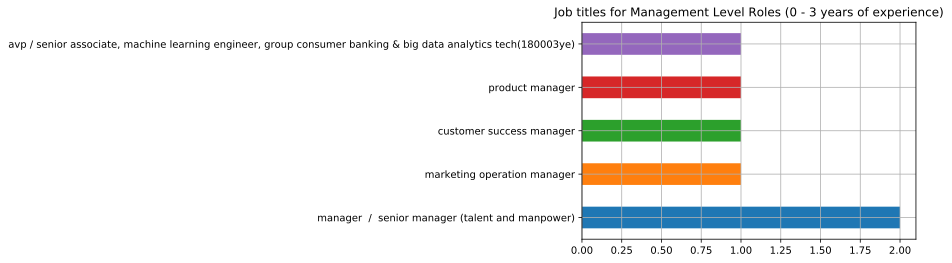

In [23]:
group = management1_df['job_title'].value_counts(normalize = False)
group.plot.barh(title = 'Job titles for Management Level Roles (0 - 3 years of experience)', grid = True)

## Salary Range

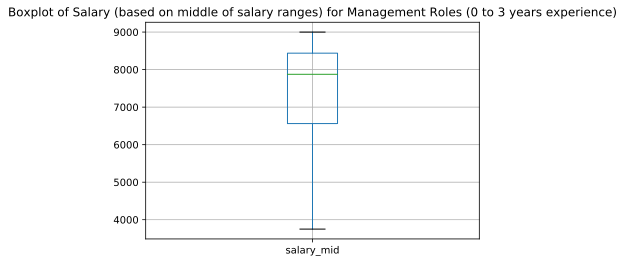

In [24]:
management1_df['salary_mid'].plot(kind='box', title = 'Boxplot of Salary (based on middle of salary ranges) for Management Roles (0 to 3 years experience)', grid = True)

## Industry
Which are the Industries that are hiring currently for these roles?

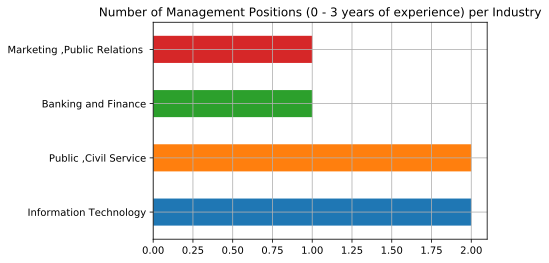

In [25]:
group = management1_df['industry'].value_counts(normalize = False)
group.plot.barh(title = 'Number of Management Positions (0 - 3 years of experience) per Industry', grid = True)

## Skills in Demand
What are the skills in demand for these roles?

In [26]:
# job requirements are stored under the 'job_requirement_nnp' Series
# Since wordcloud requires a string input, convert a series of job requirements into a string
management1_jobs_reqm = management1_df.job_requirement_nnp.str.cat(sep= ' ')

In [27]:
# Tokenise and remove punctuation & stopwords
tokens = word_tokenize(management1_jobs_reqm)
unique = set(tokens)
stop = stopwords.words('english') + ['date.successful'] + ['e.g'] + ['sicense'] + ['no'] + ['18S9180ea'] + ['singapore'] + ['smart'] + ['nation'] + ['albert'] + ['liewea']
tokens_nop = [ t for t in tokens if t not in string.punctuation ]
clean_tokens = tokens_nostop=[ t for t in tokens_nop if t not in stop ]
print(clean_tokens)

['value', 'analytical', 'business', 'finance', 'order', 'management', 'system', 'risk', 'management', 'system', 'fix', 'experienced', 'c++', 'data', 'operations', 'sales', 'english', 'computer', 'science', 'computer', 'engineering', 'statistics', 'applied', 'mathematics', 'python', 'scala', 'teradata', 'cloud', 'aws', 'ibm', 'data', 'science', 'cloudera', 'data', 'science', 'workbench', 'recruiter', 'license', '18s9180ea', 'personnel', 'value', 'analytical']


In [28]:
management1_jobs_reqm = ' '.join(clean_tokens)

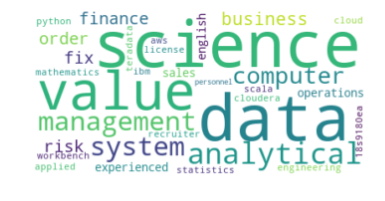

In [29]:
# View wordcloud of management 1 job requirements
management1_cloud = WordCloud(collocations=True, background_color="white").generate(management1_jobs_reqm)
# Display the generated image:
# the matplotlib way:

plt.imshow(management1_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
# Generate unigrams to have a better understanding
jb = nltk.FreqDist(clean_tokens)

# Generate bigrams to have a better understanding
bigr = nltk.bigrams(clean_tokens)
bigr = list(bigr)

# Generate trigrams to have a better understanding
trigr = nltk.trigrams(clean_tokens) 
trigr = list(trigr)

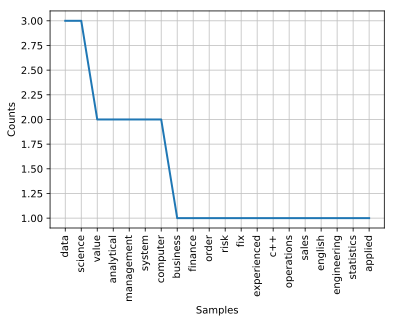

In [31]:
# Unigram frequency plot
jb.plot(20)

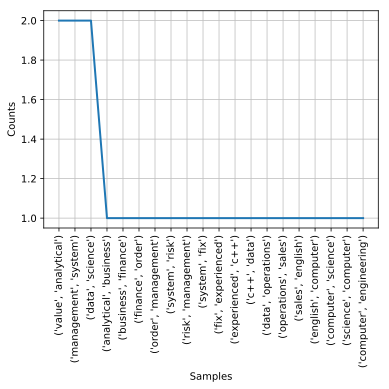

In [32]:
# Bigram frequency plot
bi_jb = nltk.FreqDist(bigr)
bi_jb.plot(20)

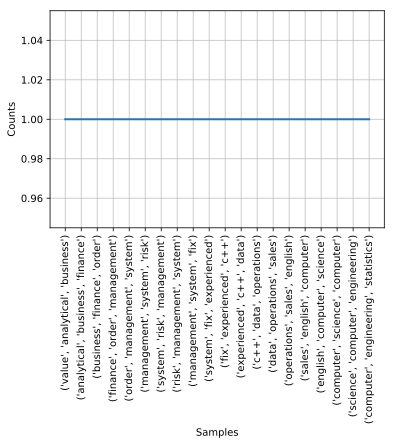

In [33]:
# Trigram frequency plot
tri_jb = nltk.FreqDist(trigr)
tri_jb.plot(20)

# Analysis for Professionals
## Job Title

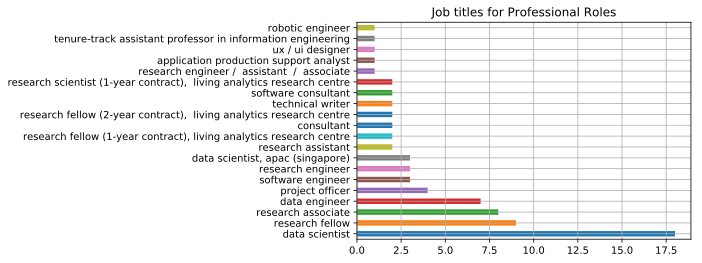

In [34]:
# Use barchart to visual what are the jobs available
group = prof_df['job_title'].value_counts(normalize = False)
group_top_20 = group.iloc[0:20]
group_top_20.plot.barh(title = 'Job titles for Professional Roles', grid = True)

## Salary Range

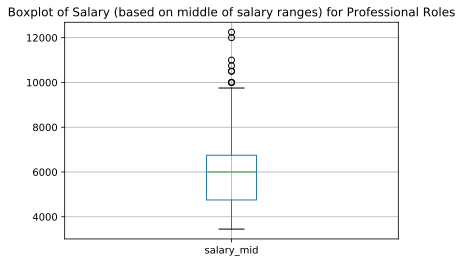

In [35]:
prof_df['salary_mid'].plot(kind='box', title = 'Boxplot of Salary (based on middle of salary ranges) for Professional Roles', grid = True)

## Industry
Which are the Industries that are hiring currently for these roles?

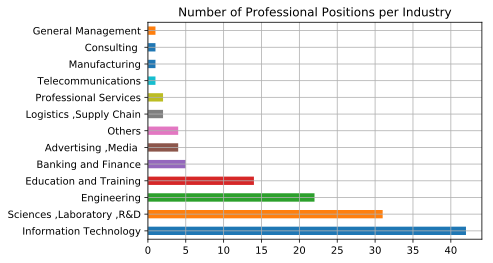

In [36]:
group = prof_df['industry'].value_counts(normalize = False)
group.plot.barh(title = 'Number of Professional Positions per Industry', grid = True)

## Skills in Demand
What are the skills in demand for these roles?

In [37]:
# job requirements are stored under the 'job_requirement_nnp' Series
# Since wordcloud requires a string input, convert a series of job requirements into a string
prof_jobs_reqm = prof_df.job_requirement_nnp.str.cat(sep= ' ')

In [38]:
# Tokenise and remove punctuation & stopwords
tokens = word_tokenize(prof_jobs_reqm)
unique = set(tokens)
stop = stopwords.words('english') + ['proficient'] + ['proven'] + ['familiar'] + ['preferred'] + ['minimum'] + ['good'] + ['singapore']
tokens_nop = [ t for t in tokens if t not in string.punctuation ]
clean_tokens = tokens_nostop=[ t for t in tokens_nop if t not in stop ]
print(clean_tokens)

['azkaban', 'airflow', 'python', 'c++', 'java', 'go', 'scala', 'kafka', 'presto', 'spark', 'aws', 'redshift', 'google', 'big', 'query', 'qubole', 'azkaban', 'airflow', 'python', 'c++', 'java', 'go', 'scala', 'kafka', 'presto', 'spark', 'aws', 'redshift', 'google', 'big', 'query', 'qubole', 'power', 'system', 'c/c++', 'python', 'jurong', 'island', 'sql', 'python', 'py', 'spark', 'scala', 'aws', 'gcp', 'advanced', 'tensorflow', 'advanced', 'analytics', 'engineering', 'products', 'master', 'statistics', 'actuarial', 'science', 'finance', 'mathematics', 'computer', 'science', 'engineering', 'economics', 'oracle', 'mssql', 'q/kdb+*', 'software', 'development', 'experience*', 'jira', 'bitbucket/git', 'confluence', 'location', 'buona', 'vista', 'michael', 'tan', 'registration', 'licence', '13c6507', 'michael.tan', 'itcs-group.com', 'computer', 'science', 'engineering', 'c/c++', 'python', 'matlab.must', 'pytorch', 'tensorflow', 'candidate', 'c++', 'java5', 'rnn', 'cnn', 'desired', 'education',

In [39]:
prof_jobs_reqm = ' '.join(clean_tokens)

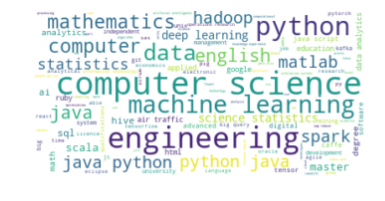

In [40]:
# View wordcloud of professional job requirements
prof_cloud = WordCloud(collocations=True, background_color="white").generate(prof_jobs_reqm)
# Display the generated image:
# the matplotlib way:

plt.imshow(prof_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
# Generate unigrams to have a better understanding
jb = nltk.FreqDist(clean_tokens)

# Generate bigrams to have a better understanding
bigr = nltk.bigrams(clean_tokens)
bigr = list(bigr)

# Generate trigrams to have a better understanding
trigr = nltk.trigrams(clean_tokens) 
trigr = list(trigr)

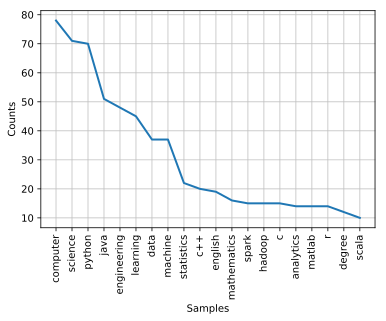

In [42]:
# Unigram frequency plot
jb.plot(20)

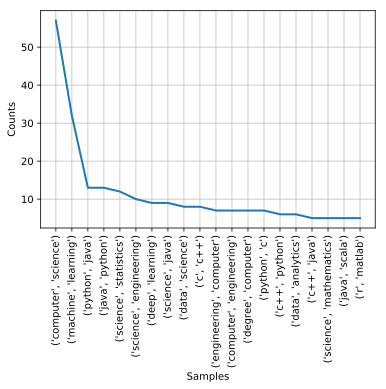

In [43]:
# Bigram frequency plot
bi_jb = nltk.FreqDist(bigr)
bi_jb.plot(20)

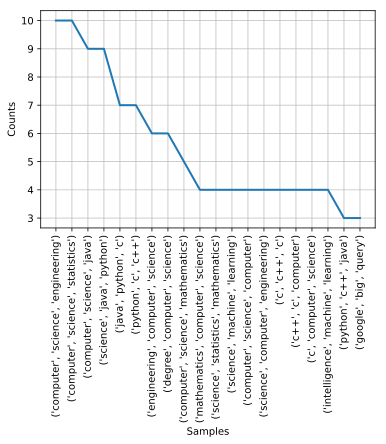

In [44]:
# Trigram frequency plot
tri_jb = nltk.FreqDist(trigr)
tri_jb.plot(20)

# Analysis for Senior Roles
## Salary Range

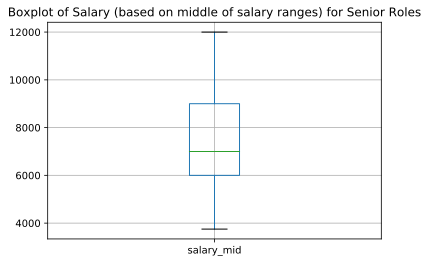

In [46]:
senior_df['salary_mid'].plot(kind='box', title = 'Boxplot of Salary (based on middle of salary ranges) for Senior Roles', grid = True)

## Skills in Demand
What are the skills in demand for these roles?

In [47]:
# job requirements are stored under the 'job_requirement_nnp' Series
# Since wordcloud requires a string input, convert a series of job requirements into a string
senior_jobs_reqm = senior_df.job_requirement_nnp.str.cat(sep= ' ')

In [48]:
# Tokenise and remove punctuation & stopwords
tokens = word_tokenize(senior_jobs_reqm)
unique = set(tokens)
stop = stopwords.words('english') + ['preferred'] + ['well'] + ['able'] + ['minimum'] + ['good'] + ['\uf0b7']
tokens_nop = [ t for t in tokens if t not in string.punctuation ]
clean_tokens = tokens_nostop=[ t for t in tokens_nop if t not in stop ]
print(clean_tokens)

['technical', 'commercial', 'java', 'python', 'py', 'skills.\uf0b7', 'big', 'hadoop', 'eco', 'system', 'hdfs', 'spark', 'google', 'cloud', 'big', 'query', 'data', 'largedatasets.\uf0b7', 'data', 'modeling', 'star', 'techniques.\uf0b7', 'real', 'time', 'systems', 'storm.\uf0b7', 'project', 'jira.\uf0b7', 'cs', 'computer', 'science', 'java', 'python', 'kafka', 'mathematics', 'economics', 'computer', 'science', 'information', 'management', 'statistics', 'r', 'and/', 'python', 'python', 'spark', 'qlik', 'view', 'bachelor', 'degree', 'r', 'python', 'data', 'analytics/data', 'science', 'advanced', 'sql', 'hive', 'presto', 'spark', 'expertise', 'r', 'python', 'data', 'tableau', 'excel', 'computer', 'science', 'proficient', 'java', 'python', 'c', 'c++', 'c', 'computer', 'machine', 'learning', 'optimization', 'python', 'degree', 'computer', 'science', 'software', 'engineering', 'statistics', 'mathematics', 'accounting/', 'finance', 'anaplan', 'oracle', 'hyperion', 'bpc', 'cognos', 'english', 's

In [49]:
senior_jobs_reqm = ' '.join(clean_tokens)

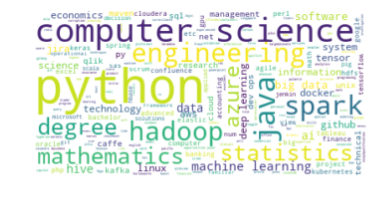

In [50]:
# View wordcloud of senior job requirements
prof_cloud = WordCloud(collocations=True, background_color="white").generate(senior_jobs_reqm)
# Display the generated image:
# the matplotlib way:

plt.imshow(prof_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
# Generate unigrams to have a better understanding
jb = nltk.FreqDist(clean_tokens)

# Generate bigrams to have a better understanding
bigr = nltk.bigrams(clean_tokens)
bigr = list(bigr)

# Generate trigrams to have a better understanding
trigr = nltk.trigrams(clean_tokens) 
trigr = list(trigr)

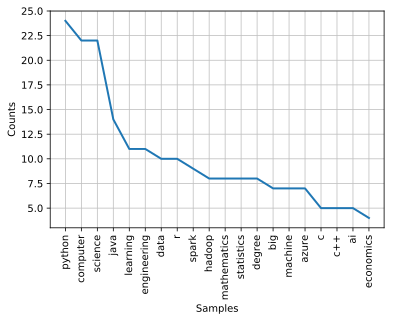

In [52]:
# Unigram frequency plot
jb.plot(20)

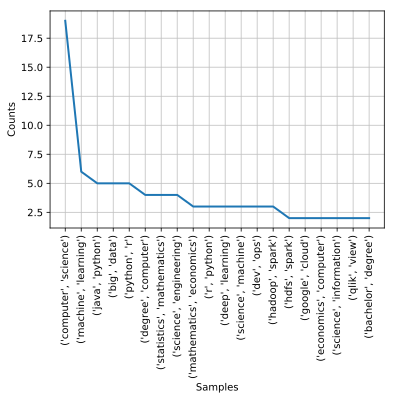

In [53]:
# Bigram frequency plot
bi_jb = nltk.FreqDist(bigr)
bi_jb.plot(20)

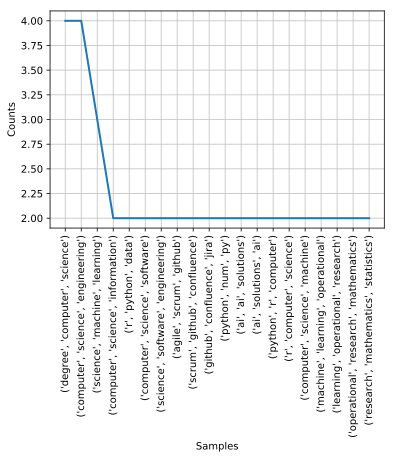

In [54]:
# Trigram frequency plot
tri_jb = nltk.FreqDist(trigr)
tri_jb.plot(20)

# Analysis for Management Roles (more than 3 years of experience)
## Salary Range

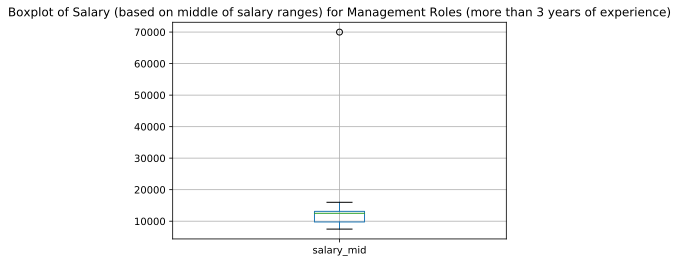

In [55]:
management2_df['salary_mid'].plot(kind='box', title = 'Boxplot of Salary (based on middle of salary ranges) for Management Roles (more than 3 years of experience)', grid = True)

## Skills in Demand
What are the skills in demand for these roles?

In [56]:
# job requirements are stored under the 'job_requirement_nnp' Series
# Since wordcloud requires a string input, convert a series of job requirements into a string
management2_jobs_reqm = management2_df.job_requirement_nnp.str.cat(sep= ' ')

In [57]:
# Tokenise and remove punctuation & stopwords
tokens = word_tokenize(management2_jobs_reqm)
unique = set(tokens)
stop = stopwords.words('english') + ['plus'] + ['interest'] + ['license'] + ['minimum'] + ['personnel'] + ['–'] + ['opportunities'] + ['able'] + ['fluent'] + ['e.g'] + ['excellent'] + ['18s9180ea'] + ['albert'] + ['liewea']
tokens_nop = [ t for t in tokens if t not in string.punctuation ]
clean_tokens = tokens_nostop=[ t for t in tokens_nop if t not in stop ]
print(clean_tokens)

['life', 'science', 'english', 'python', 'sql', 'mar', 'tech', 'singapore', 'asean', 'thailand', 'vietnam', 'indonesia', 'english', 'mandarin', 'china', 'e.', 'commerce', 'google', 'analytics', 'ai', 'machine', 'learning', 'data', 'borac', 'computer', 'science', 'rdbms', 'nosql', 'teamwork', 'results.client', 'management', 'building', 'open', 'worldwide', 'employee', 'stock', 'singapore', 'reporting', 'policy.3+', 'recruiter', 'environment.-', 'cloud', 'software.-', 'ux', 'gtm', 'phd-level', 'python', 'scala', 'recruiter', 'internet', 'technology', 'recruiter']


In [58]:
management2_jobs_reqm = ' '.join(clean_tokens)

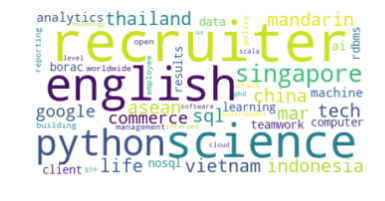

In [59]:
# View wordcloud of management (4 years or more experience) job requirements
management2_cloud = WordCloud(collocations=True, background_color="white").generate(management2_jobs_reqm)
# Display the generated image:
# the matplotlib way:

plt.imshow(management2_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [60]:
# Generate unigrams to have a better understanding
jb = nltk.FreqDist(clean_tokens)

# Generate bigrams to have a better understanding
bigr = nltk.bigrams(clean_tokens)
bigr = list(bigr)

# Generate trigrams to have a better understanding
trigr = nltk.trigrams(clean_tokens) 
trigr = list(trigr)

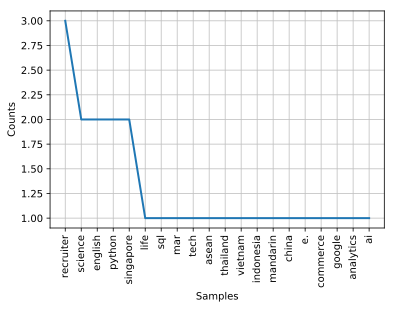

In [61]:
# Unigram frequency plot
jb.plot(20)

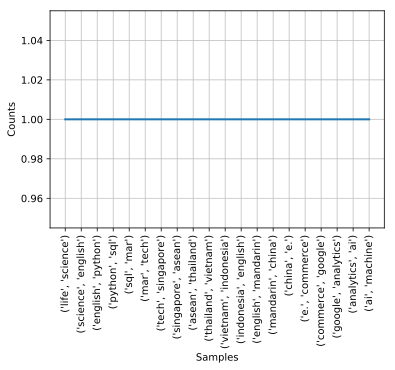

In [62]:
# Bigram frequency plot
bi_jb = nltk.FreqDist(bigr)
bi_jb.plot(20)

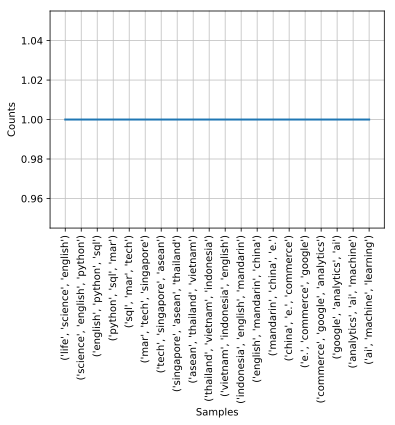

In [63]:
# Trigram frequency plot
tri_jb = nltk.FreqDist(trigr)
tri_jb.plot(20)